In [ ]:
# ! pip uninstall surface_erasure_decoding
# ! pip3 install git+https://github.com/JiakaiW/surface_erasure_decoding

In [1]:
from surface_erasure_decoding import job_fixed_num_errors
import uuid
import itertools
import pickle
import zipfile
import os
import math
import matplotlib.pyplot as plt
import json
import datetime

In [2]:
from __future__ import annotations
from collections.abc import Callable,Sequence
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LogNorm
import numpy as np
from matplotlib.figure import Figure
from matplotlib.pyplot import Axes
from oscar import Landscape
from oscar import CustomExecutor
import matplotlib.ticker as ticker
from oscar import CSReconstructor

import sys
sys.path.append('..')
from surface_erasure_decoding import *
from IPython.display import clear_output

In [3]:
import statsmodels.stats.proportion as smp

def wilson_score_interval(x, n, confidence=0.95):
    """
    Compute the Wilson score confidence interval for a binomial proportion using statsmodels.
    
    Parameters:
    x : int
        Number of successes (yes outcomes).
    n : int
        Number of trials.
    confidence : float
        Confidence level for the interval (e.g., 0.95 for 95% confidence).
    
    Returns:
    (lower_bound, upper_bound) : tuple of floats
        Lower and upper bounds of the confidence interval.
    """
    lower_bound, upper_bound = smp.proportion_confint(x, n, alpha=1-confidence, method='wilson')
    return lower_bound, upper_bound

def generate_bool_array(tot, choose):
    array = np.zeros(tot, dtype=bool)
    indices = np.random.choice(tot, choose, replace=False)
    assert len(indices) == choose
    array[indices] = True
    return array

def get_weight(num_dice_e,num_dice_p,num_e_flipped,num_p_flipped,p_e,p_p):
    # Calculate binomial coefficients
    binom_e = math.comb(num_dice_e, num_e_flipped)
    binom_p = math.comb(num_dice_p, num_p_flipped)
    
    prob_e = (p_e ** num_e_flipped) * ((1 - p_e) ** (num_dice_e - num_e_flipped))
    prob_p = (p_p ** num_p_flipped) * ((1 - p_p) ** (num_dice_p - num_p_flipped))
    
    # Calculate the weight
    weight = binom_e * prob_e * binom_p * prob_p
    return weight

In [4]:
d = 3
p_e=0.02
p_p=0.001
after_cz_error_model = get_2q_error_model(p_e=p_e,
                                        p_p=p_p)
builder = easure_circ_builder(rounds = d,
                                distance= d,
                                after_cz_error_model=after_cz_error_model,
                                measurement_error=0
                                )
builder.generate_helper()
builder.gen_dummy_circuit()

non_trivial_gate_error_models = [attr_value for attr_name, attr_value in vars(builder).items() if isinstance(attr_value, GateErrorModel) and not  attr_value.trivial]
assert len(non_trivial_gate_error_models) == 1

tot_e = non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].dummy_generator.num_qubit_called
tot_p = non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].dummy_generator.num_qubit_called

num_qubit_per_dice_e = non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].deterministic_generator.num_qubit_per_dice
num_qubit_per_dice_p = non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].deterministic_generator.num_qubit_per_dice

num_dice_e = int(tot_e/num_qubit_per_dice_e)
num_dice_p = int(tot_p/num_qubit_per_dice_p)

builder.gen_erasure_conversion_circuit()
erasure_circ_next_ancilla_qubit_index = builder.next_ancilla_qubit_index_in_list[0]
converter = builder.erasure_circuit.compile_m2d_converter()

# num dice is the total number of potential error locations for erasure (e) and 2-qubit depolarization (p)
num_dice_e, num_dice_p

(144, 72)

100%|██████████| 144/144 [00:00<00:00, 1721.75it/s]
/tmp/ipykernel_22639/1150076909.py:32: UserWarning: Log scale: values of z <= 0 have been masked
  contour_set = plt.contour(weights, levels=[cutoff_value], colors='red', linewidths=3, norm=LogNorm(vmin=1e-20, vmax=1), origin='lower')
/tmp/ipykernel_22639/1150076909.py:34: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_path = contour_set.collections[0].get_paths()[0]


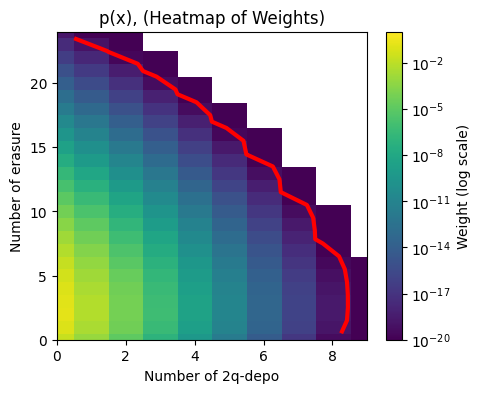

In [5]:
# Define the ranges for num_e_flipped and num_p_flipped
num_e_flipped_range = np.arange(0, num_dice_e,1)
num_p_flipped_range = np.arange(0, num_dice_p, 1)
 
# Initialize the weight matrix
weights = np.zeros((len(num_e_flipped_range), len(num_p_flipped_range)))

# Calculate weights for each combination of num_e_flipped and num_p_flipped
for i, num_e_flipped in enumerate(tqdm(num_e_flipped_range)):
    for j, num_p_flipped in enumerate(num_p_flipped_range):
        weights[i, j] = get_weight(num_dice_e, num_dice_p, num_e_flipped, num_p_flipped, p_e, p_p)



p_tolerance = 1e-13
flattened_weights = weights.flatten()
sorted_weights = np.sort(flattened_weights)#[::-1]
cumulative_sum = np.cumsum(sorted_weights)
cumulative_prob = cumulative_sum / cumulative_sum[-1]
cutoff_index = np.searchsorted(cumulative_prob, p_tolerance)
cutoff_value = sorted_weights[cutoff_index] if cutoff_index < len(sorted_weights) else sorted_weights[-1]

# Create the heatmap
plt.figure(figsize=(5, 4))
plt.imshow(weights, norm=LogNorm(vmin=1e-20,vmax = 1), origin='upper', cmap='viridis', aspect='auto')
plt.colorbar(label='Weight (log scale)')
plt.xlabel('Number of p_flipped')
plt.ylabel('Number of e_flipped')
plt.title('Heatmap of Weights')


contour_set = plt.contour(weights, levels=[cutoff_value], colors='red', linewidths=3, norm=LogNorm(vmin=1e-20, vmax=1), origin='lower')
# Extract the path of the contour at level v
contour_path = contour_set.collections[0].get_paths()[0]

# Get the coordinates of the contour line
contour_coords = contour_path.vertices
x_coords = contour_coords[:, 0]
y_coords = contour_coords[:, 1]


x_min = np.floor(x_coords.min()).astype(int)
x_max = np.ceil(x_coords.max()).astype(int)
y_min = np.floor(y_coords.min()).astype(int)
y_max = np.ceil(y_coords.max()).astype(int)

# Set xlim and ylim using the min and max values
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel('Number of 2q-depo')
plt.ylabel('Number of erasure')
plt.title('p(x), (Heatmap of Weights)')

plt.show()

In [6]:
reduced_num_p_arr = np.arange(x_min,x_max+1)
reduced_num_e_arr = np.arange(y_min,y_max+1)

num_shots_arr = np.zeros(shape=(len(reduced_num_p_arr),len(reduced_num_e_arr)))
num_errors_arr = np.zeros(shape=(len(reduced_num_p_arr),len(reduced_num_e_arr)))

shots = 1e2
counter  = 0
jobs_info = []
for i, num_p in enumerate([0,5,7]):
    for j, num_e in enumerate([3,10,20]):
        circuit_id=str(uuid.uuid4())
        job_id=str(uuid.uuid4())
        job = job_fixed_num_errors.Sample_decode_job(
                        job_id=job_id,
                        circuit_id=circuit_id,
                        d = d,
                        p_e=p_e,
                        p_p=p_p,
                        p_z_shift= 0.0,
                        p_m = 0.0,
                        shots=int(shots),
                        num_e_flipped = num_e,
                        num_p_flipped = num_p,
                        )
        with open(f"{counter}.pkl", "wb") as f:
            pickle.dump(job, f)
        counter += 1

        jobs_info.append({
            "job_id": job_id,
            "circuit_id": circuit_id,
            "d": d,
            "p_e": p_e,
            "p_z_shift": 0.0,
            "p_p": p_p,
            "p_m": 0.0,
            "shots": shots,
            "file": f"{counter}.pkl"
        })
print(f"num_jobs: {counter}")

# Save jobs information to a JSON file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
json_filename = f"jobs_info_{timestamp}.json"
with open(json_filename, "w") as json_file:
    json.dump(jobs_info, json_file, indent=4)


num_jobs: 9


In [7]:

def pack_pkl_files_to_zip(zip_filename="importance_sampling_input.zip"):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for filename in os.listdir('.'):
            name, ext = os.path.splitext(filename)
            if ext == '.pkl' and name.isdigit():
                zipf.write(filename)
                os.remove(filename)
                
pack_pkl_files_to_zip(zip_filename="importance_sampling_input_test.zip")

In [12]:
len(jobs_info)

9

In [11]:
import os
import json
import pandas as pd

json_list = []
directory = "erasure_decode_result_v1"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)


df = pd.DataFrame(json_list)


In [13]:
pd.set_option('display.max_rows', 10)

df.head(10)

,job_id,circuit_id,d,p_e,p_z_shift,p_p,p_m,shots,new_circ
0,6cee8fa1-a6fb-4c46-a591-12825f0d1ad4,0168de08-7b57-4f96-9d6a-cde9041f3d91,3,0.04,0.0,0.001,0.000,16000,97
1,32da4fba-fade-4cb8-a7ad-f90a9a38690a,af8a51ff-300c-42cd-abe7-6dce37072720,3,0.05,0.0,0.006,0.000,16000,596
2,0b8ff09e-b3ce-4fb5-95e1-a962b9b7027d,266edf13-94eb-47c6-a02d-ceaca9e1cca5,9,0.08,0.0,0.006,0.001,2000,385
3,55d0cc8d-eafb-4e01-96ae-406eec4e5e7f,bb1c26b5-5675-42cc-84c1-b86048738d2d,9,0.01,0.0,0.010,0.001,2000,84
4,ea85d1fb-0ad8-40e7-9cee-d64f248b0e89,e28ef0cf-500e-4b37-aba4-b52e6c5785a8,9,0.07,0.0,0.002,0.000,2000,56
5,6c16385d-ebc0-4275-977c-f8d3279aa3a0,72cf1493-3930-4545-8dfd-c1eb437ea659,9,0.08,0.0,0.001,0.000,2000,40
6,addada7f-1d99-443a-918f-456a18548832,ab87ca0d-a715-44cc-846d-2558b21df641,9,0.06,0.0,0.010,0.001,2000,441
7,928e4df7-25f5-47a4-aa0c-7b5574b287a4,09fedd31-0d72-4f9e-9d14-a0062ce92905,7,0.07,0.0,0.002,0.001,4000,103
8,669fd280-a147-4ba7-8067-9b7a6badf50f,85092b88-feb1-480f-88bd-539189f58e41,9,0.02,0.0,0.006,0.000,2000,11
9,e02ef330-2ddf-4456-828c-6d8c0b40ce7c,84a7879a-e89e-48ed-8533-a830f56c88dd,9,0.05,0.0,0.010,0.000,2000,351


In [32]:
# df.drop('job_id', axis=1, inplace=True)
agg_rules = {
    'shots': 'sum',
    'new_circ': 'sum',
    # 'normal': 'sum',
    'p_e': 'first',
    'p_z_shift': 'first',
    'p_p': 'first',
    'p_m': 'first',
}

df_grouped = df.groupby(['circuit_id', 'd']).agg(agg_rules).reset_index()
df_grouped['p_logi_era'] = df_grouped['new_circ'] / df_grouped['shots']
# df_grouped['p_logi_normal'] = df_grouped['normal'] / df_grouped['shots']

pd.set_option('display.max_rows', 15)
df_grouped.head(15)

,circuit_id,d,shots,new_circ,p_e,p_z_shift,p_p,p_m,p_logi_era
0,0135d3f5-f822-4cda-80cb-57a9c71543b4,7,80000,6963,0.05,0.0,0.008,0.000,0.087038
1,01667e00-260b-4d13-9c10-a8dec345b476,7,80000,40,0.02,0.0,0.002,0.000,0.000500
2,0168de08-7b57-4f96-9d6a-cde9041f3d91,3,32000,188,0.04,0.0,0.001,0.000,0.005875
3,01941919-9f9a-4a7e-a063-6d4fa645ed3c,7,80000,627,0.03,0.0,0.004,0.001,0.007838
4,01f1ee67-d92c-49ff-8e01-e11d8a735a7e,7,80000,5957,0.06,0.0,0.006,0.001,0.074463
5,04c52334-7d8d-43b6-915d-85dd8fb7cc01,9,148000,51640,0.08,0.0,0.010,0.001,0.348919
6,0519e499-2540-427e-9106-524481ba7bf5,9,148000,657,0.05,0.0,0.002,0.001,0.004439
7,052b7f6a-f7f3-4034-84d0-e23727caa144,5,48000,4783,0.08,0.0,0.006,0.000,0.099646
8,056eac90-bd1a-4b6f-a6f4-43a2c45d62b1,7,80000,406,0.06,0.0,0.001,0.000,0.005075
9,058226f6-6b1a-45cc-a5c6-8655c2cd912b,5,48000,959,0.01,0.0,0.008,0.001,0.019979


In [31]:
# After grouping there should be 96 * 4 = 384 rows.
df_grouped

,circuit_id,d,shots,new_circ,p_e,p_z_shift,p_p,p_m,p_logi_era
0,0135d3f5-f822-4cda-80cb-57a9c71543b4,7,80000,6963,0.05,0.0,0.008,0.000,0.087038
1,01667e00-260b-4d13-9c10-a8dec345b476,7,80000,40,0.02,0.0,0.002,0.000,0.000500
2,0168de08-7b57-4f96-9d6a-cde9041f3d91,3,32000,188,0.04,0.0,0.001,0.000,0.005875
3,01941919-9f9a-4a7e-a063-6d4fa645ed3c,7,80000,627,0.03,0.0,0.004,0.001,0.007838
4,01f1ee67-d92c-49ff-8e01-e11d8a735a7e,7,80000,5957,0.06,0.0,0.006,0.001,0.074463
...,...,...,...,...,...,...,...,...,...
379,fa5813e5-db9f-43eb-930c-554a6b90ffb9,3,32000,906,0.04,0.0,0.006,0.000,0.028313
380,fbd69e6a-43fb-4d33-86ef-813100651d5a,3,32000,770,0.02,0.0,0.008,0.000,0.024063
381,fcad2946-59bb-4b8d-ba65-8579794a2e54,9,148000,332,0.02,0.0,0.004,0.001,0.002243
382,fe13c9be-7766-44b5-96a8-b8b3ab763bf4,9,148000,34318,0.06,0.0,0.010,0.000,0.231878


In [15]:
def compute_binary_confidence_interval(num_positive, n_samples, confidence_level=0.95):
    p_hat = num_positive / n_samples  # Estimated probability
    standard_error = math.sqrt((p_hat * (1 - p_hat)) / n_samples)
    z = 1.96  # For a 95% confidence level
    margin_of_error = z * standard_error
    lower_bound = p_hat - margin_of_error
    upper_bound = p_hat + margin_of_error
    lower_bound = max(0,lower_bound)
    return lower_bound, upper_bound


In [21]:
def plot_logi_vs_intrin(p_e,p_m, p_z_shift):
    df = df_grouped
    filtered_df = df.loc[(df['p_e'] == p_e) &
                         (df['p_m'] == p_m) &
                         (df['p_z_shift'] == p_z_shift)]

    group_by_columns = ['d']        

    for _, group in filtered_df.groupby(group_by_columns):
        distance = group.iloc[0]['d']
        x_values = group['p_p']
        y_values = group['p_logi_era']

        x_y_values = zip(x_values, y_values)
        sorted_xy_values = sorted(x_y_values, key=lambda v: v[0])
        sorted_x, sorted_y = zip(*sorted_xy_values)
        color = unsaturated_colors['blue'].get(distance, 'blue')
        plt.plot(sorted_x, sorted_y, color=color, label=f'd_{distance}_conditional_prob_decoding')
        
        # CI
        m = group['new_circ']
        n = group['shots']
        m_n_x_values = zip(m, n,x_values)
        sorted_mn_values = sorted(m_n_x_values, key=lambda v: v[-1])
        sorted_m, sorted_n,sorted_x = zip(*sorted_mn_values)
        num_positive = sorted_m
        n_samples = sorted_n
        lower_bound, upper_bound = zip(*[compute_binary_confidence_interval(num, n) for num, n in zip(num_positive, n_samples)])
        plt.fill_between(sorted_x, lower_bound, upper_bound, color=color, alpha=0.3)

    # Set log scales for both x and y axes
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    # Set plot labels and legend
    plt.title(f'leakage{p_e},p_z from shift{p_z_shift}')
    plt.xlabel('p_intrin')
    plt.ylabel('Per shot logical error')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()




def make_logi_vs_intrin_widget():
    interactive_plot = interactive(plot_logi_vs_intrin,
                p_e = p_e_list,
                p_m = p_m_list,
                p_z_shift = p_z_shift_list)
    return interactive_plot


make_logi_vs_intrin_widget()

interactive(children=(Dropdown(description='p_e', options=(0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08), va…

# Now I have a dataframe that describe p_logi_era as a function of d, p_e, p_p, (and p_m). I want to know if a (p_e, p_p) is above or below the threshold.

In [105]:
import numpy as np

print(f"num p_e {len(p_e_list)}, num p_p {len(p_p_list)}")
distances = [3,5,7,9]
slope_array = []
for p_e in p_e_list:
    slope_array.append([])
    for p_p in p_p_list:
        p_log = []
        for d in distances:
            p_log.append(
                df_grouped.loc[(df_grouped['d'] == d) &
                        (df_grouped['p_e'] == p_e) &
                        (df_grouped['p_p'] == p_p) &
                        (df_grouped['p_m'] == p_m_list[-1]) &
                        (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]
            )
            if p_log[-1] == 0:
                p_log[-1] = 1e-5
        slope, intercept = np.polyfit(x=distances, y=np.log(p_log), deg = 1)
        formatted_floats = [f"{num:.2e}" for num in p_log]
        print(f"p_log: {formatted_floats}, base = {slope}")
        slope_array[-1].append(slope)
    
slope_array = np.array(slope_array)

num p_e 8, num p_p 6
p_log: ['9.37e-04', '1.67e-04', '1.00e-05', '1.00e-05'], base = -0.8217652855655795
p_log: ['2.78e-03', '8.75e-04', '1.12e-04', '7.43e-05'], base = -0.6458961534203801
p_log: ['6.44e-03', '4.44e-03', '2.02e-03', '8.31e-04'], base = -0.34630130036938406
p_log: ['1.20e-02', '9.12e-03', '7.13e-03', '5.18e-03'], base = -0.1379240924823586
p_log: ['1.75e-02', '2.00e-02', '1.87e-02', '1.65e-02'], base = -0.012022639516067822
p_log: ['2.68e-02', '3.24e-02', '3.59e-02', '3.92e-02'], base = 0.06179989639668201
p_log: ['1.87e-03', '3.96e-04', '8.75e-05', '2.03e-05'], base = -0.7545490193716123
p_log: ['4.84e-03', '1.35e-03', '5.50e-04', '1.69e-04'], base = -0.5484550124394829
p_log: ['9.47e-03', '6.15e-03', '4.13e-03', '2.24e-03'], base = -0.2359465474158543
p_log: ['1.61e-02', '1.54e-02', '1.30e-02', '1.05e-02'], base = -0.07353202056168084
p_log: ['2.56e-02', '2.76e-02', '2.96e-02', '2.92e-02'], base = 0.023630977018482383
p_log: ['3.34e-02', '4.45e-02', '5.26e-02', '6.17e

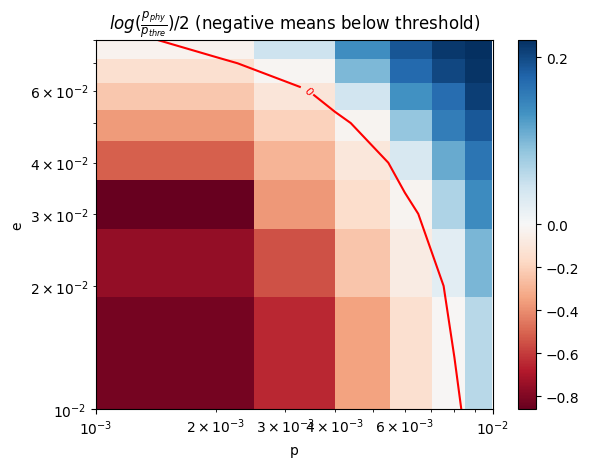

In [139]:
import matplotlib.colors as mcolors


plt.title(rf'$log(\frac{{p_{{phy}}}}{{p_{{thre}}}})/2$ (negative means below threshold)')
plt.xlabel('p')
plt.ylabel('e')
plt.imshow(slope_array, cmap= 'RdBu', norm= mcolors.TwoSlopeNorm(vmin = np.min(slope_array),vcenter = 0,vmax = np.max(slope_array)),
        extent=[ p_p_list[0], p_p_list[-1],  p_e_list[0], p_e_list[-1]], aspect='auto',origin='lower')
plt.colorbar()

X, Y = np.meshgrid(p_p_list, p_e_list)

# Plot the contour line at z = 0
contour = plt.contour(X, Y, slope_array, levels=[0], colors='red')

# Optionally add labels
plt.clabel(contour, inline=True, fontsize=8)

plt.xscale('log')
plt.yscale('log')
